In [1]:
import requests
import pandas as pd
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt

In [2]:
USERNAME ='OOIAPI-2VGT2I58H9V44G'
TOKEN= 'HFYV49OQEJ6'
DATA_API_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

In [3]:
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()
pst_delta = 8*3600

def ntp_seconds_to_datetime(ntp_seconds):
    timestamp = datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
    utc_timezone = pytz.timezone('UTC')
    pst_timezone = pytz.timezone('US/Pacific')
    time = utc_timezone.localize(timestamp).astimezone(pst_timezone)
    return time

In [4]:
data_request_url = ['https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE02SHSM/SBD11/06-METBKA000/telemetered/metbk_a_dcl_instrument?beginDT=2019-01-01T00:31:20.712Z&endDT=2019-12-31T00:31:20.712Z&limit=1000',
                   'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/CE04OSSM/SBD11/06-METBKA000/telemetered/metbk_a_dcl_instrument?beginDT=2019-01-01T04:33:58.629Z&endDT=2019-12-31T04:33:58.629Z&limit=1000']

In [5]:
OSSM_time = []
OSSM_velocity = []
OSSM_precipitation = []

OOSM_time = []
OOSM_velocity = []
OOSM_precipitation = []

C:\Users\neilt\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


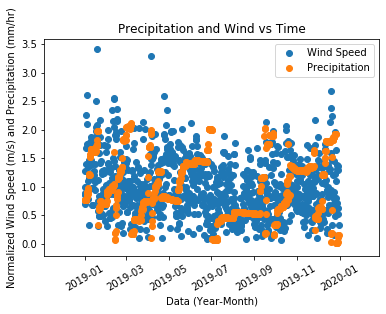

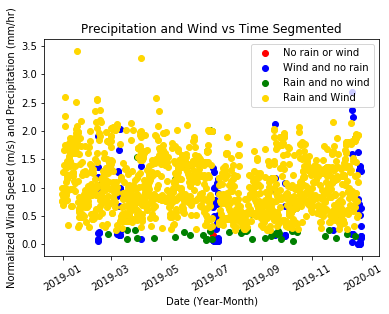

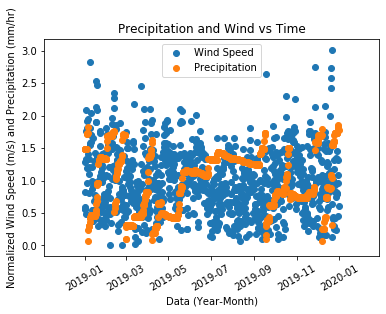

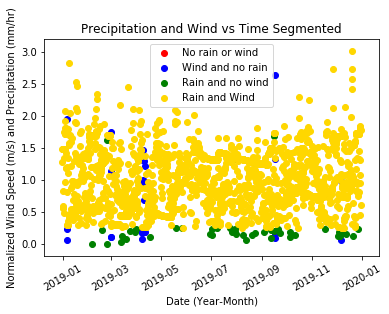

In [6]:
for i in range(len(data_request_url)):
    r = requests.get(data_request_url[i], auth=(USERNAME, TOKEN))
    data = r.json()
    time = []
    velocity = []
    precipitation = []
    
    for j in range(len(data)):
        time.append(ntp_seconds_to_datetime(data[j]['time']))
        wind_direction = np.sqrt((np.square(data[j]['northward_wind_velocity']))+(np.square(data[j]['eastward_wind_velocity'])))
        velocity.append(wind_direction)
        precipitation.append(data[j]['precipitation'])
        if i == 0:
            OSSM_time.append(ntp_seconds_to_datetime(data[j]['time']))
            OSSM_velocity.append(wind_direction)
            OSSM_precipitation.append(data[j]['precipitation'])
        elif i == 1:
            OOSM_time.append(ntp_seconds_to_datetime(data[j]['time']))
            OOSM_velocity.append(wind_direction)
            OOSM_precipitation.append(data[j]['precipitation'])
    
    from numpy import *
    velocity = np.asarray(velocity)
    where_are_NaNs = isnan(velocity)
    velocity[where_are_NaNs] = 0
    
    time1 = []
    velocity1 = []
    precipitation1 = []
    time2 = []
    velocity2 = []
    precipitation2 = []
    time3 = []
    velocity3 = []
    precipitation3 = []
    time4 = []
    velocity4 = []
    precipitation4 = []

    for i in range(len(time)):
        if velocity[i]/np.mean(velocity) < .25 and precipitation[i]/np.mean(precipitation) < .25:
            #Case 1: No rain or wind
            time1.append(time[i])
            velocity1.append(velocity[i]/np.mean(velocity))
            precipitation1.append(precipitation[i]/np.mean(precipitation))
        elif velocity[i]/np.mean(velocity) >= .25 and precipitation[i]/np.mean(precipitation) < .25:
            #Case 2: Wind and no rain
            time2.append(time[i])
            velocity2.append(velocity[i]/np.mean(velocity))
            precipitation2.append(precipitation[i]/np.mean(precipitation))
        elif velocity[i]/np.mean(velocity) < .25 and precipitation[i]/np.mean(precipitation) >= .25:
            #Case 3: Rain and no wind
            time3.append(time[i])
            velocity3.append(velocity[i]/np.mean(velocity))
            precipitation3.append(precipitation[i]/np.mean(precipitation))
        else:
            #Case 4: Rain and Wind
            time4.append(time[i])
            velocity4.append(velocity[i]/np.mean(velocity))
            precipitation4.append(precipitation[i]/np.mean(precipitation))
    
    plt.scatter(time,velocity/np.mean(velocity),label = 'Wind Speed')
    plt.scatter(time,precipitation/np.mean(precipitation),label = 'Precipitation')
    plt.legend()
    plt.xticks(rotation=30)
    plt.xlabel('Data (Year-Month)')
    plt.ylabel('Normalized Wind Speed (m/s) and Precipitation (mm/hr)')
    plt.title('Precipitation and Wind vs Time')
    plt.show()
    plt.scatter(time1,velocity1,color = 'red',label = 'No rain or wind')
    plt.scatter(time1,precipitation1,color = 'red')
    plt.scatter(time2,velocity2,color = 'blue')
    plt.scatter(time2,precipitation2,color = 'blue',label = 'Wind and no rain')
    plt.scatter(time3,velocity3,color = 'green')
    plt.scatter(time3,precipitation3,color = 'green',label = 'Rain and no wind')
    plt.scatter(time4,velocity4,color = 'gold')
    plt.scatter(time4,precipitation4,color = 'gold',label = 'Rain and Wind')
    plt.legend()
    plt.xticks(rotation=30)
    plt.xlabel('Date (Year-Month)')
    plt.ylabel('Normalized Wind Speed (m/s) and Precipitation (mm/hr)')
    plt.title('Precipitation and Wind vs Time Segmented')
    plt.show()

max correlation is at lag 0
Lag in Days: 0
max correlation is 0.6314010061301172


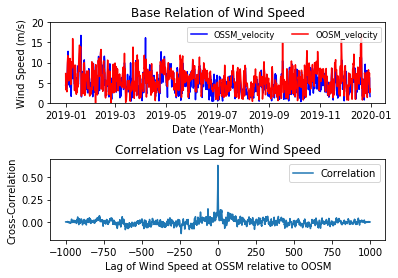

In [16]:
OSSM_velocity = np.asarray(OSSM_velocity)
where_are_NaNs = isnan(OSSM_velocity)
OSSM_velocity[where_are_NaNs] = 0
OOSM_velocity = np.asarray(OOSM_velocity)
where_are_NaNs = isnan(OOSM_velocity)
OOSM_velocity[where_are_NaNs] = 0

y1 = OSSM_velocity
y2 = OOSM_velocity

x = time

lags = np.arange(-len(y1) + 1, len(y1))
ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
ccor = ccov / (len(y1) * y1.std() * y2.std())

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x, y1, 'b', label='OSSM_velocity')
ax.plot(x, y2, 'r', label='OOSM_velocity')
ax.set_ylim(0, 20)
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('Base Relation of Wind Speed')
ax.set_ylabel('Wind Speed (m/s)')
ax.set_xlabel('Date (Year-Month)')


ax = axs[1]
ax.plot(lags, ccor, label='Correlation')
ax.legend()
ax.set_ylim(-.2, .7)
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag of Wind Speed at OSSM relative to OOSM')
ax.set_title('Correlation vs Lag for Wind Speed')

plt.subplots_adjust(hspace=.7)

maxlag = lags[np.argmax(ccor)]
print("max correlation is at lag %d" % maxlag)
days = (maxlag/len(time))*365
print('Lag in Days: %d' % days)
maxccor = np.max(ccor)
print('max correlation is ' + str(maxccor))

max correlation is at lag 341
Lag in Days: 124
max correlation is 0.3515930061267975


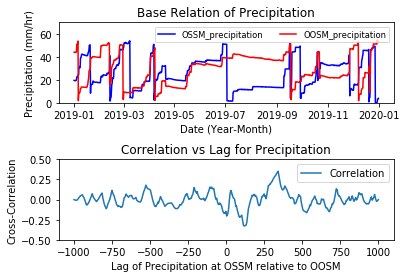

In [17]:
y1 = np.asarray(OSSM_precipitation)
y2 = np.asarray(OOSM_precipitation)

x = time

lags = np.arange(-len(y1) + 1, len(y1))
ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
ccor = ccov / (len(y1) * y1.std() * y2.std())

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x, y1, 'b', label='OSSM_precipitation')
ax.plot(x, y2, 'r', label='OOSM_precipitation')
ax.set_ylim(0, 70)
ax.legend(loc='upper right', fontsize='small', ncol=2)
ax.set_title('Base Relation of Precipitation')
ax.set_ylabel('Precipitation (mm/hr)')
ax.set_xlabel('Date (Year-Month)')

ax = axs[1]
ax.plot(lags, ccor, label='Correlation')
ax.legend()
ax.set_ylim(-.5, .5)
ax.set_ylabel('Cross-Correlation')
ax.set_xlabel('Lag of Precipitation at OSSM relative to OOSM')
ax.set_title('Correlation vs Lag for Precipitation')

plt.subplots_adjust(hspace=.7)

maxlag = lags[np.argmax(ccor)]
print("max correlation is at lag %d" % maxlag)
days = (maxlag/len(time))*365
print('Lag in Days: %d' % days)
maxccor = np.max(ccor)
print('max correlation is ' + str(maxccor))